In [76]:
import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

In [77]:
df = pd.read_csv('f1_race_features.csv')

In [78]:
df.head()

,season,round,event_name,location,driver_code,driver_name,team_name,final_position,won,podium,points_scored,grid_position,race_experience,weighted_avg_position,weighted_avg_points,recent_form_3races,recent_points_3races,podiums_last_5races,consistency_std_position,finish_rate,avg_grid_position_history,avg_grid_to_race_gain,avg_position_on_circuit,circuit_experience
0,2021,4,Spanish Grand Prix,Barcelona,ALO,Fernando Alonso,Alpine,17.0,0,0,0.0,10.0,3,9.479793,2.905692,12.333333,5.0,0,5.859465,0.666667,12.333333,0.000000,9.479793,0
1,2021,5,Monaco Grand Prix,Monte Carlo,ALO,Fernando Alonso,Alpine,13.0,0,0,0.0,17.0,4,13.760392,1.211737,11.666667,5.0,0,5.322906,0.500000,11.750000,-1.750000,13.760392,0
2,2021,6,Azerbaijan Grand Prix,Baku,ALO,Fernando Alonso,Alpine,6.0,0,0,8.0,8.0,5,13.312638,0.726420,12.666667,4.0,0,4.615192,0.400000,12.800000,-0.600000,13.312638,0
3,2021,7,French Grand Prix,Le Castellet,ALO,Fernando Alonso,Alpine,8.0,0,0,4.0,9.0,6,10.642438,3.410594,12.000000,8.0,0,5.115336,0.500000,12.000000,-0.166667,10.642438,0
4,2021,8,Styrian Grand Prix,Spielberg,ALO,Fernando Alonso,Alpine,9.0,0,0,2.0,8.0,7,9.981199,3.445314,9.000000,12.0,0,4.928054,0.571429,11.571429,0.000000,9.981199,0


In [79]:
df.shape

(2094, 24)

In [80]:
df.isnull().sum()

season                       0
round                        0
event_name                   0
location                     0
driver_code                  0
driver_name                  0
team_name                    0
final_position               3
won                          0
podium                       0
points_scored                0
grid_position                3
race_experience              0
weighted_avg_position        0
weighted_avg_points          0
recent_form_3races           0
recent_points_3races         0
podiums_last_5races          0
consistency_std_position     0
finish_rate                  0
avg_grid_position_history    0
avg_grid_to_race_gain        0
avg_position_on_circuit      0
circuit_experience           0
dtype: int64

In [81]:
# Retirar valores nulos
df.dropna(inplace=True)

In [82]:
train = df[df['season'] <= 2024]
test  = df[df['season'] == 2025]

In [83]:
y_train = train['podium']
y_test  = test['podium']

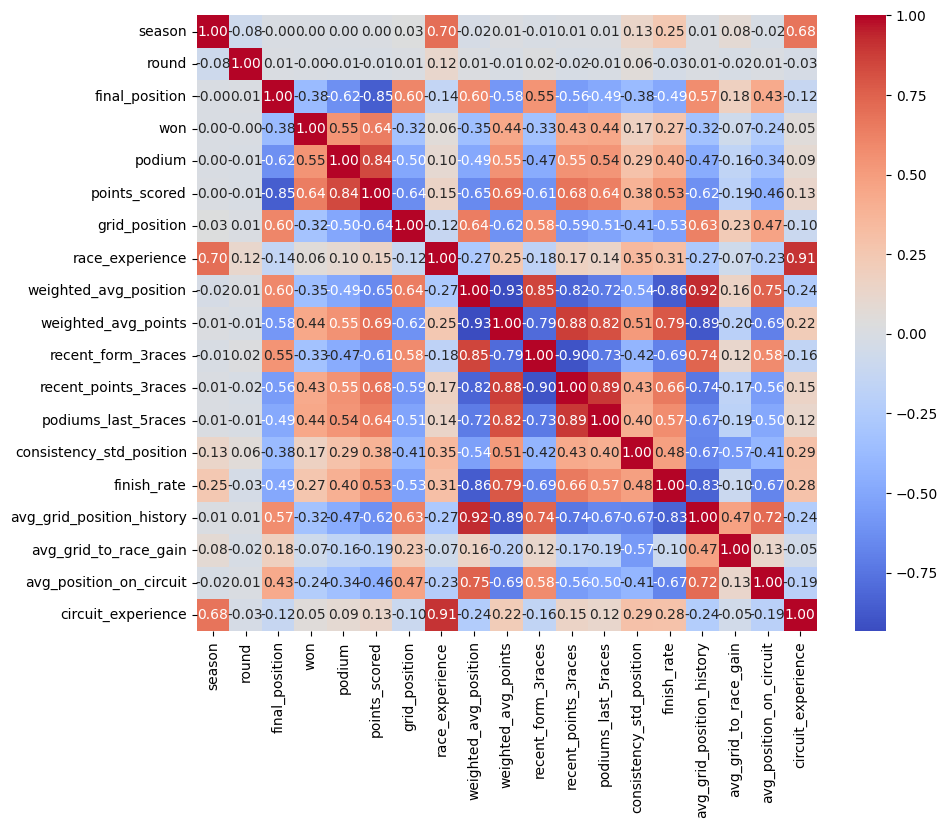

In [128]:
df_num = df.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

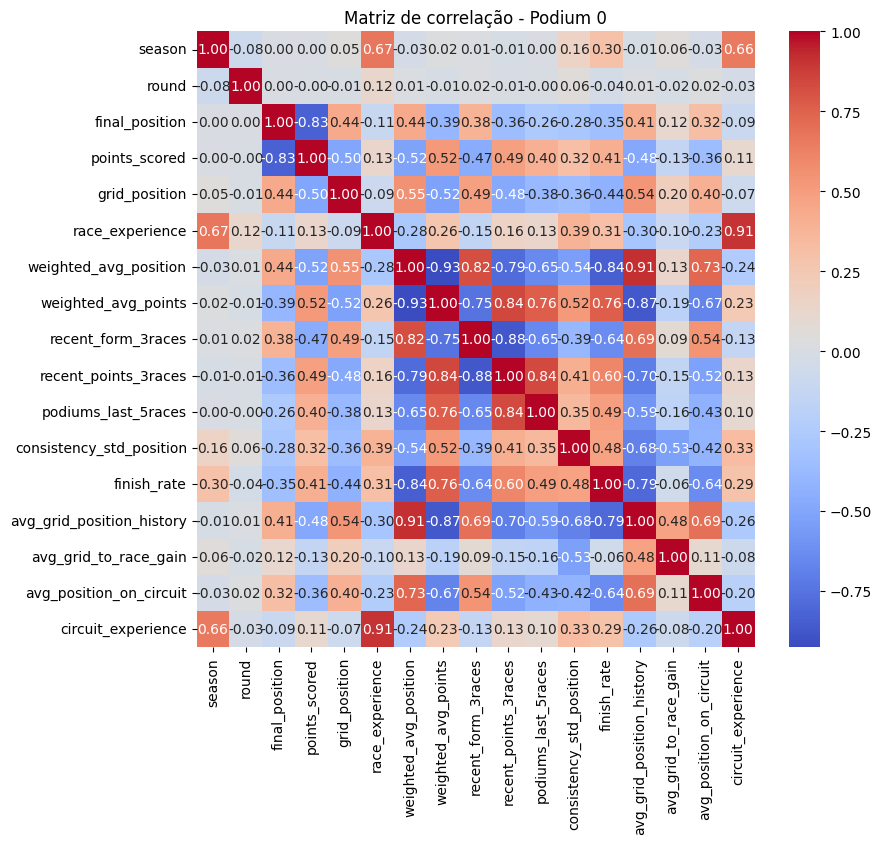

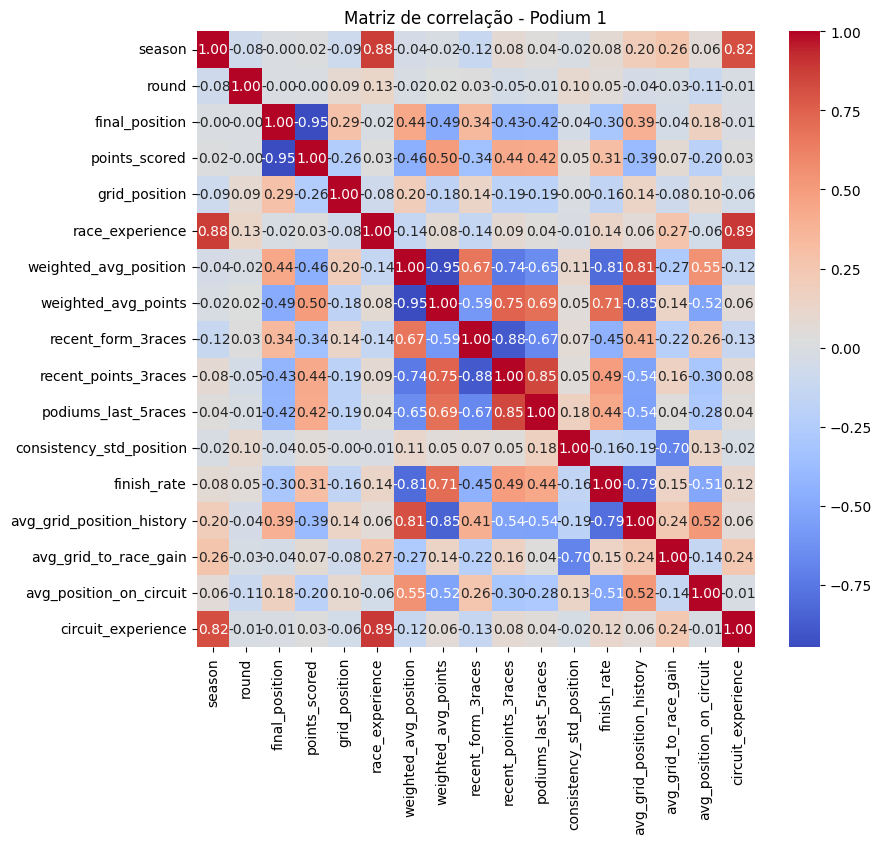

In [142]:
df_num = df.select_dtypes(include='number').drop(columns=['won','podium'])
for c in df['podium'].unique():
    df_c = df_num[df['podium'] == c]
    plt.figure(figsize=(9,8))
    sns.heatmap(df_c.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"Matriz de correlação - Podium {c}")
    plt.show()

> Verifica-se que se trata de um problema com dados desbalanceados, visto que há predominância da classe em que não se tem motoristas em podium em relação quantidade de motoristas em pódio

> sempre vai ter o mesmo número de pessoas no pódio. isso pode influenciar o modelo?
> modelo levar em conta proficiência de cada pista por piloto
> consistencia do piloto da corrida > fator do quanto o piloto eh bom
- incluir consistência do piloto em ano anterior > media da posição/tempo na corrida nos ultimos anos

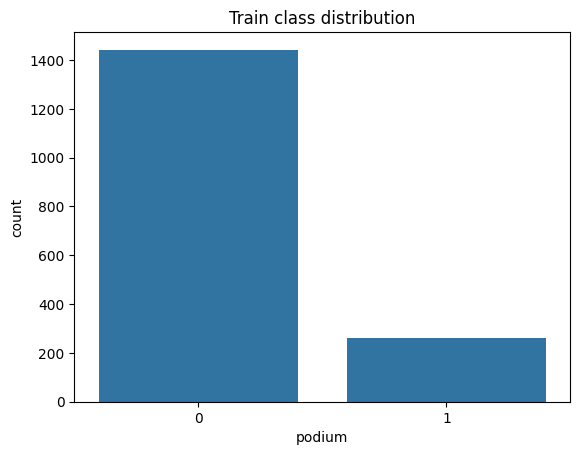

In [84]:
sns.countplot(x=y_train)
plt.title("Train class distribution")
plt.show()

In [146]:
cols_to_drop = [
    'season',
    'final_position',
    'won',
    'podium',
    'points_scored',
    'driver_code',
    'driver_name',
    'team_name',
    'event_name',
    'location'
]

X_train = train.drop(columns=cols_to_drop, errors='ignore')
X_test  = test.drop(columns=cols_to_drop, errors='ignore')

X_train.shape

(1703, 14)

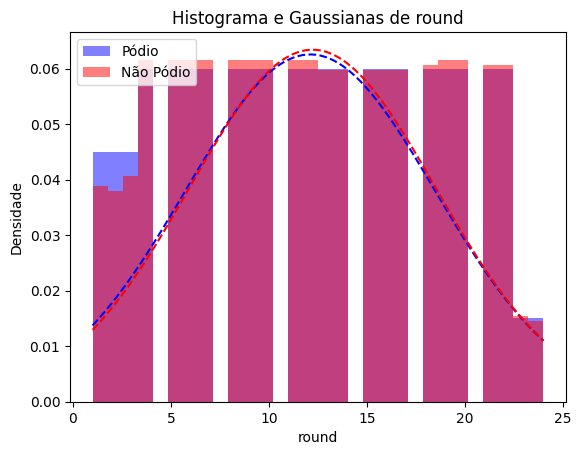

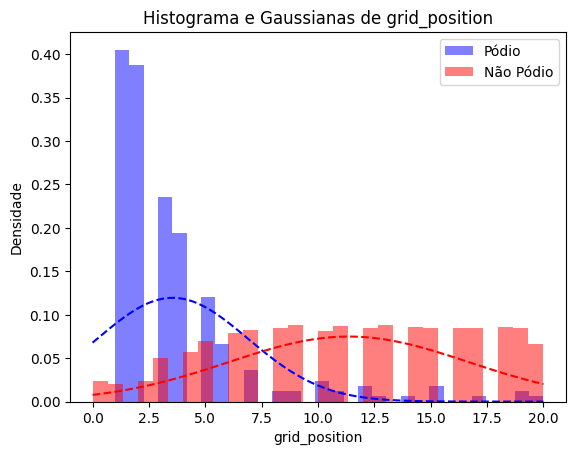

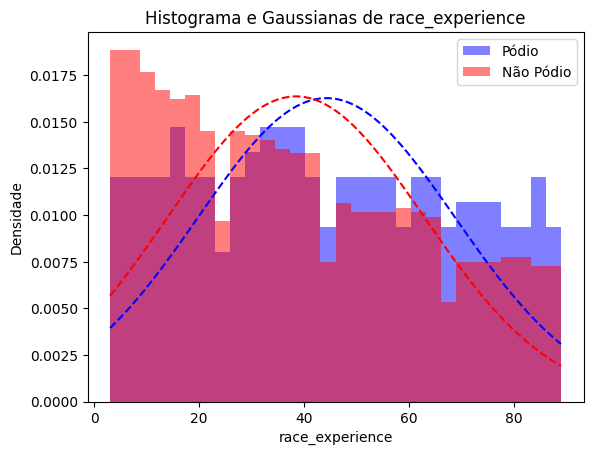

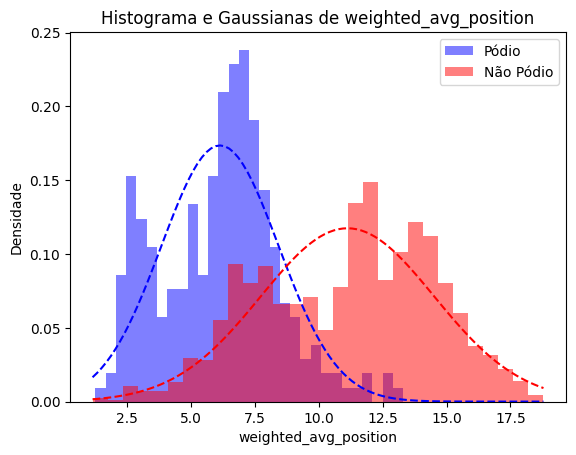

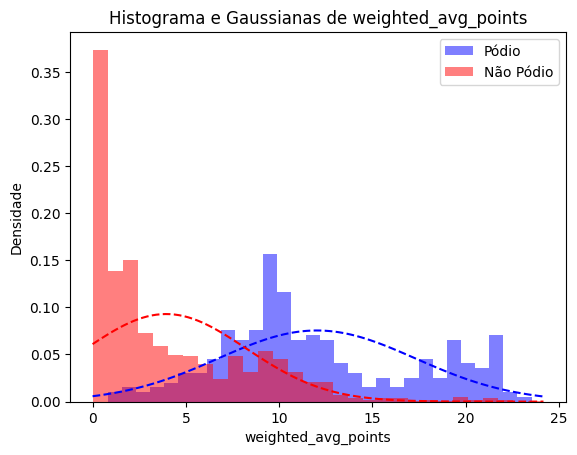

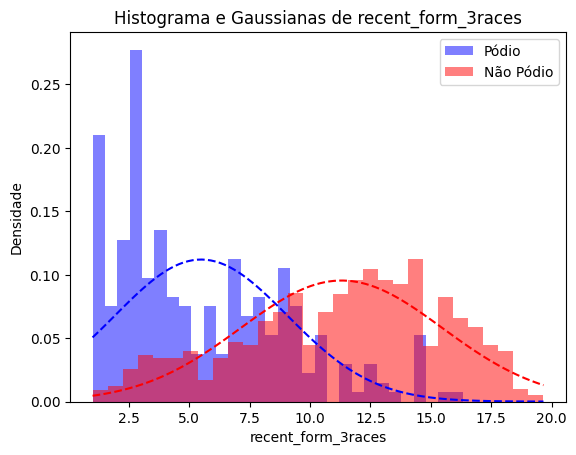

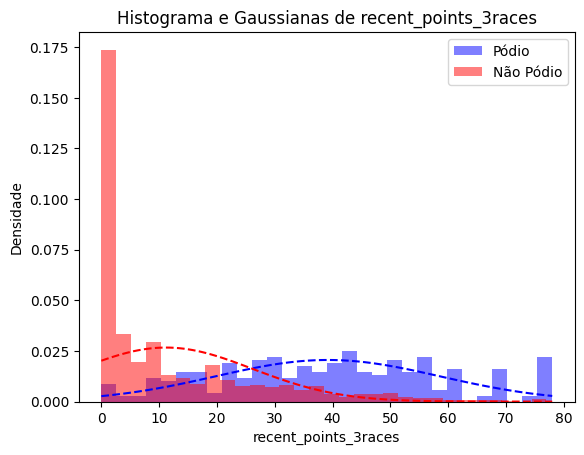

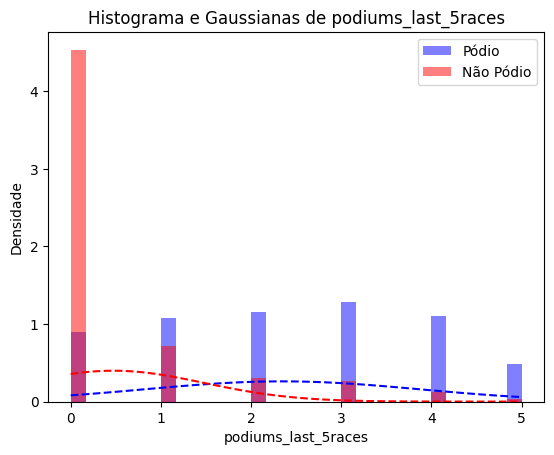

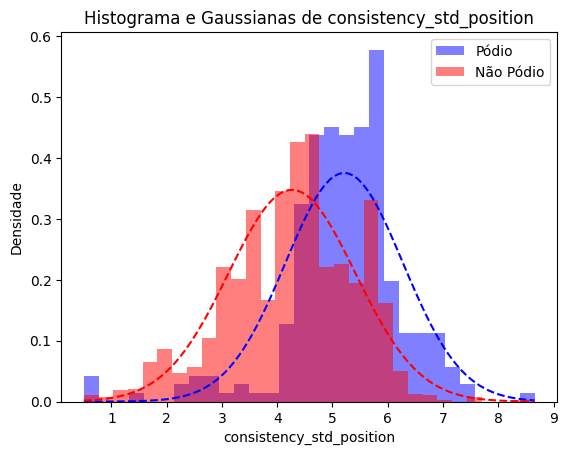

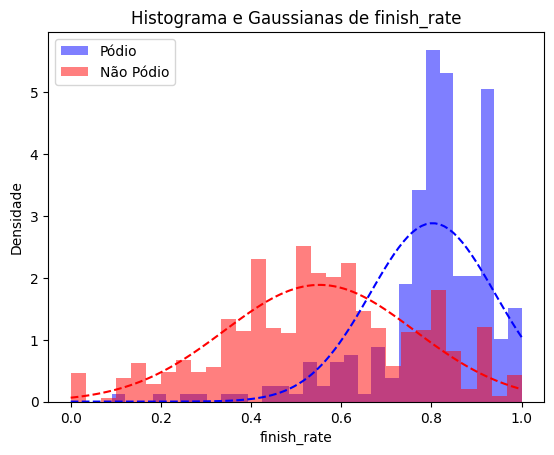

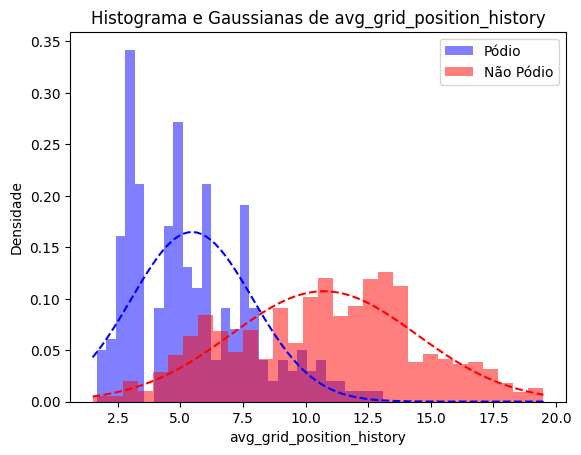

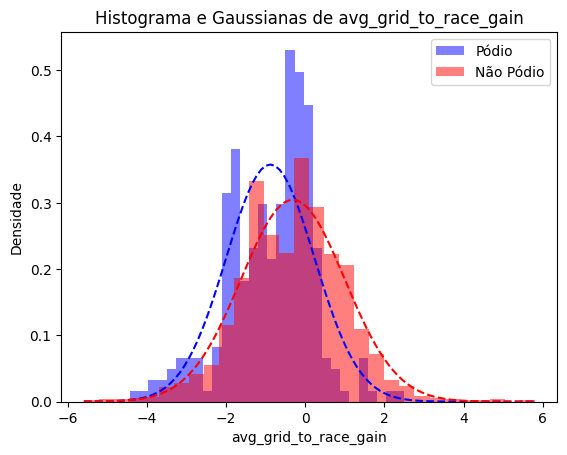

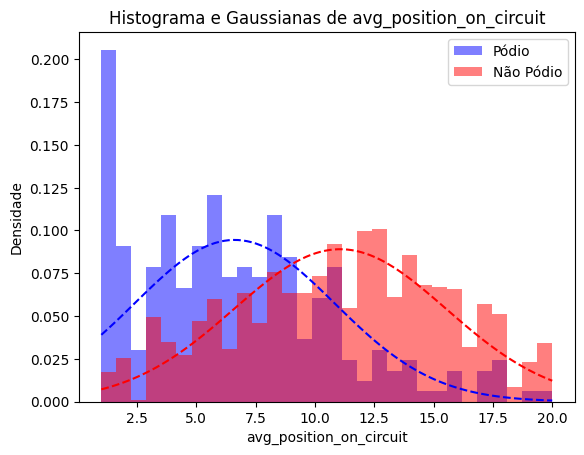

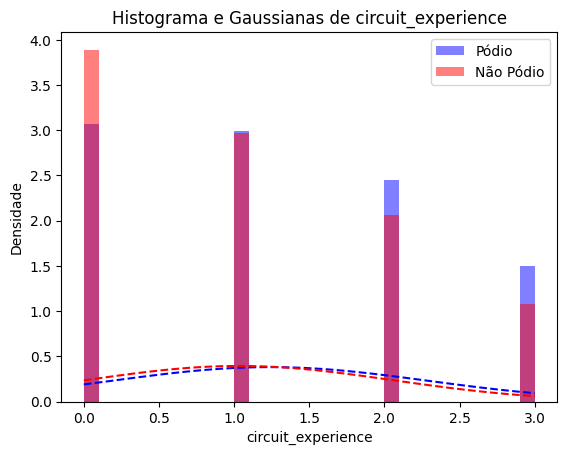

In [86]:
from scipy.stats import norm

# suposição: X_train é DataFrame, y_train = 1 se pódio, 0 se não
for col in X_train.columns:
    plt.figure()
    
    # dados por classe
    data_podio = X_train[col][y_train == 1]
    data_nao = X_train[col][y_train == 0]
    
    # histograma
    plt.hist(data_podio, bins=30, alpha=0.5, label='Pódio', color='blue', density=True)
    plt.hist(data_nao, bins=30, alpha=0.5, label='Não Pódio', color='red', density=True)
    
    # Gaussianas
    mu_p, std_p = data_podio.mean(), data_podio.std()
    mu_n, std_n = data_nao.mean(), data_nao.std()
    
    x = np.linspace(X_train[col].min(), X_train[col].max(), 100)
    plt.plot(x, norm.pdf(x, mu_p, std_p), 'b--')  # curva gaussiana pódio
    plt.plot(x, norm.pdf(x, mu_n, std_n), 'r--')  # curva gaussiana não pódio
    
    plt.title(f'Histograma e Gaussianas de {col}')
    plt.xlabel(col)
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

In [87]:
scorings = {
    "f1_macro": "f1_macro",
    "recall_1": make_scorer(recall_score, pos_label=1),
    "accuracy": "accuracy"
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    # Métricas treino
    preds_train = model.predict(X_train)
    results_train = {
        "Accuracy": accuracy_score(y_train, preds_train),
        "Macro-F1": f1_score(y_train, preds_train, average="macro"),
        "Recall_Classe_1": recall_score(y_train, preds_train, pos_label=1)
    }

    # Métricas teste
    preds_test = model.predict(X_test)
    results_test = {
        "Accuracy": accuracy_score(y_test, preds_test),
        "Macro-F1": f1_score(y_test, preds_test, average="macro"),
        "Recall_Classe_1": recall_score(y_test, preds_test, pos_label=1)
    }

    print("Treino:\n", classification_report(y_train, preds_train))
    print("Teste:\n", classification_report(y_test, preds_test))

    return results_train, results_test

## Model Analysis

In [88]:
all_results = {}

### Nayve Bayes

In [89]:
X_train.columns

Index(['round', 'grid_position', 'race_experience', 'weighted_avg_position',
       'weighted_avg_points', 'recent_form_3races', 'recent_points_3races',
       'podiums_last_5races', 'consistency_std_position', 'finish_rate',
       'avg_grid_position_history', 'avg_grid_to_race_gain',
       'avg_position_on_circuit', 'circuit_experience'],
      dtype='object')

In [125]:
pipe_nb = Pipeline([
  ('scaler', StandardScaler()),
  ('nb', GaussianNB())
])

results_nb = evaluate_model(pipe_nb, X_train, y_train, X_test, y_test)
results_nb

Treino:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1442
           1       0.44      0.82      0.58       261

    accuracy                           0.82      1703
   macro avg       0.70      0.82      0.73      1703
weighted avg       0.88      0.82      0.83      1703

Teste:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89       328
           1       0.47      0.93      0.63        60

    accuracy                           0.83       388
   macro avg       0.73      0.87      0.76       388
weighted avg       0.91      0.83      0.85       388



({'Accuracy': 0.8150322959483265,
  'Macro-F1': 0.7288777115640331,
  'Recall_Classe_1': 0.8199233716475096},
 {'Accuracy': 0.8298969072164949,
  'Macro-F1': 0.7594227950847394,
  'Recall_Classe_1': 0.9333333333333333})

O modelo possui uma acurácia global de aproximadamente 83%, mas com um comportamento assimétrico entre as classes. A classe 1 tem um recall muito alto de 93%, enquanto sua precisão é bem mais baixa (47%). Isso significa que o modelo quase não deixa de identificar os casos positivos, mas gera muitos falsos positivos. O valor do Macro-F1, em torno de 0.76, reflete o trade-off de um bom desempenho médio  entre as cçares, mas com o viés em favor da sensibilidade da classe minoritária

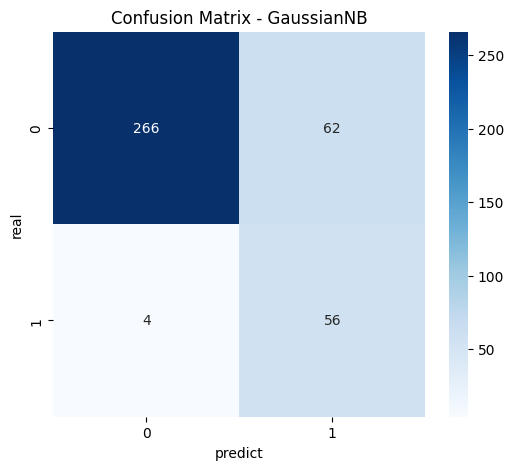

In [124]:
pipe_nb.fit(X_train, y_train)
pred_nb = pipe_nb.predict(X_test)

cm = confusion_matrix(y_test, pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - GaussianNB")
plt.xlabel("predict")
plt.ylabel("real")
plt.show()

A matriz de confusão mostra que o modelo tem um alto recall para a classe 1 (detecta quase todos os positivos), porém comete muitos falsos positivos, classificando vários exemplos da classe 0 como 1. Isso indica que o modelo está enviesado para marcar casos como positivos devido à alta variância da classe 1

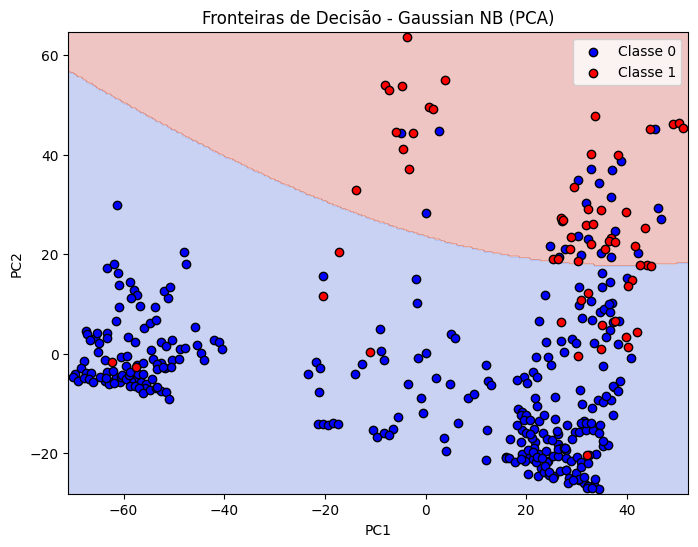

In [92]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

nb_pca = GaussianNB()
nb_pca.fit(X_test_pca, y_test)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = nb_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - Gaussian NB (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

A visualização das fronteiras de decisão revela que o GaussianNB cria uma separação suave e ampla para a classe 1, cobrindo grande parte do espaço. Isso explica os falsos positivos observados: a fronteira não consegue capturar bem a estrutura real dos dados e acaba rotulando como classe 1 regiões densamente povoadas por exemplos da classe 0.

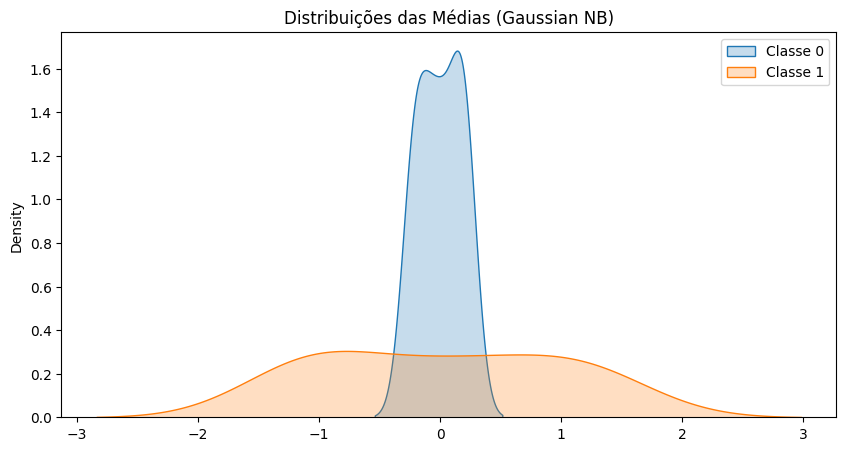

In [93]:
means = pipe_nb.named_steps['nb'].theta_

plt.figure(figsize=(10,5))
sns.kdeplot(means[0], fill=True, label="Classe 0")
sns.kdeplot(means[1], fill=True, label="Classe 1")
plt.title("Distribuições das Médias (Gaussian NB)")
plt.legend()
plt.show()

O gráfico de densidade mostra que a classe 1 possui uma distribuição muito mais dispersa do que a classe 0. Essa diferença de curtose faz o GaussianNB expandir demais a região de decisão da classe 1, resultando em maior sensibilidade, porém com baixa precisão, que é exatamente o comportamento visto nas métricas

-Naive Bayes: temos bastante correlação entre as variáveis, o que é ruim pra esse classificador. A classe 1 tem uma correlação muito menor que a classe 0. A média de ambas as classes é a mesma (zero), sendo a classe 1 muito mais platicúrtica. Isso faz o NB superestimar a classe 1: Precisão da classe 1 baixa mas recall alto. "Joga todo mundo na classe 1.". Muitos falsos positivos! Não temos parâmetros pra mudar no modelo, é isso mesmo que temos de resultado.

### LDA

In [143]:
pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

results_lda = evaluate_model(pipe_lda, X_train, y_train, X_test, y_test)
results_lda

Treino:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      1442
           1       0.64      0.53      0.58       261

    accuracy                           0.88      1703
   macro avg       0.78      0.74      0.76      1703
weighted avg       0.88      0.88      0.88      1703

Teste:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       328
           1       0.67      0.68      0.68        60

    accuracy                           0.90       388
   macro avg       0.81      0.81      0.81       388
weighted avg       0.90      0.90      0.90       388



({'Accuracy': 0.8831473869641808,
  'Macro-F1': 0.7574339737161744,
  'Recall_Classe_1': 0.5325670498084292},
 {'Accuracy': 0.8994845360824743,
  'Macro-F1': 0.8090719828401993,
  'Recall_Classe_1': 0.6833333333333333})

O LDA possui um desempenho equilibrado entre as classes, com alta precisão e recall para a classe 0 (≈94%) e resultados moderados para a classe 1 (≈68%). Diferente do GaussianNB, o LDA reduz drasticamente os falsos positivos, aumentando a precisão da classe 1, mas ainda perde alguns positivos por limitações de separação linear. O Macro-F1 de ~0.81 reflete essa melhora de equilíbrio geral.

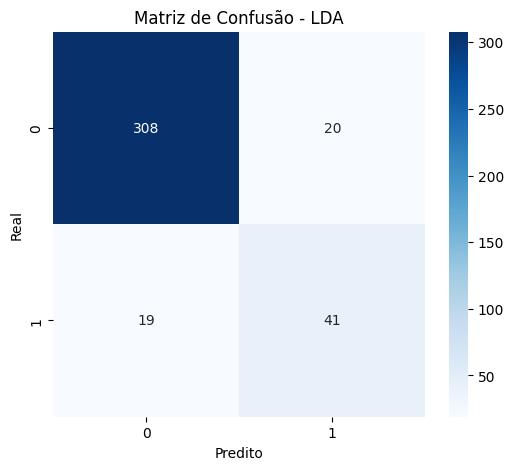

In [144]:
pipe_lda.fit(X_train, y_train)
pred_lda = pipe_lda.predict(X_test)

cm_lda = confusion_matrix(y_test, pred_lda)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - LDA")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

A matriz de confusão mostra que o LDA classifica muito bem a classe 0 e apresenta desempenho razoável na classe 1, errando tanto positivos quanto negativos em proporção menor que o GaussianNB. Os 19 falsos negativos da classe 1 indicam que alguns casos positivos ainda ficam próximos da fronteira linear e são classificados como 0

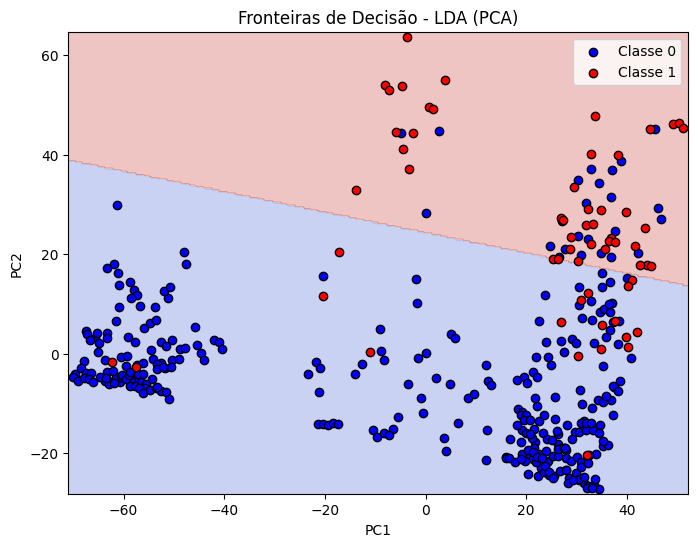

In [96]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_test_pca, y_test)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = lda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

# pontos reais, separados por classe
plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - LDA (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão do LDA no espaço PCA é linear, refletindo a suposição do modelo. Essa fronteira separa bem regiões densas da classe 0, mas deixa vários pontos da classe 1 do lado azul, evidenciando que a separação linear não captura totalmente a estrutura das classes em duas dimensões.

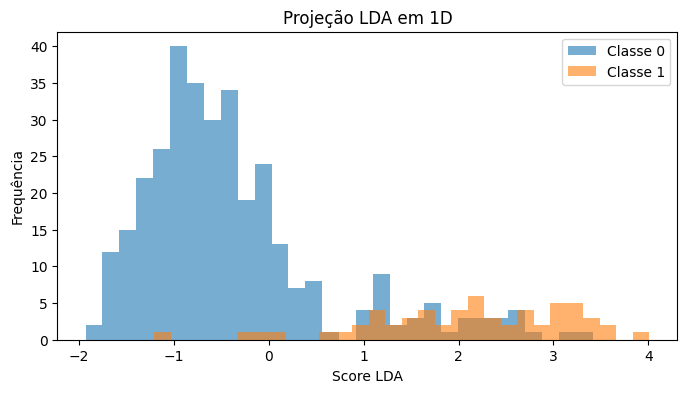

In [97]:
X_test_scaled = StandardScaler().fit_transform(X_test)
lda_1d = LinearDiscriminantAnalysis(n_components=1)
X_lda_1d = lda_1d.fit_transform(X_test_scaled, y_test)

plt.figure(figsize=(8,4))
plt.hist(X_lda_1d[y_test == 0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(X_lda_1d[y_test == 1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Projeção LDA em 1D")
plt.xlabel("Score LDA")
plt.ylabel("Frequência")
plt.legend()
plt.show()

A projeção em 1D mostra duas distribuições parcialmente separadas: a classe 0 concentrada em valores negativos e a classe 1 deslocada para valores positivos. Entretanto, a sobreposição entre as curvas revela por que ainda ocorrem erros, embora o LDA encontre uma direção de maior separação, as classes não são perfeitamente distintas nesse espaço linear

### QDA

In [98]:
pipe_qda = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])

results_qda = evaluate_model(pipe_qda, X_train, y_train, X_test, y_test)
results_qda

Treino:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      1442
           1       0.48      0.82      0.60       261

    accuracy                           0.84      1703
   macro avg       0.72      0.83      0.75      1703
weighted avg       0.89      0.84      0.85      1703

Teste:
               precision    recall  f1-score   support

           0       0.98      0.84      0.91       328
           1       0.51      0.88      0.65        60

    accuracy                           0.85       388
   macro avg       0.74      0.86      0.78       388
weighted avg       0.90      0.85      0.87       388



({'Accuracy': 0.8355842630651791,
  'Macro-F1': 0.7498478648620291,
  'Recall_Classe_1': 0.8160919540229885},
 {'Accuracy': 0.8505154639175257,
  'Macro-F1': 0.7757851107922844,
  'Recall_Classe_1': 0.8833333333333333})

O QDA apresenta um recall muito alto para a classe 1 (≈88%), semelhante ao GaussianNB, mas com precisão maior e menos falsos positivos. A acurácia e o F1 da classe 0 permanecem altos (≈91%), enquanto o F1 da classe 1 melhora em relação ao NB, mas ainda sofre com sobreposição entre distribuições. O Macro-F1 de ~0.78 indica que o modelo equilibra razoavelmente bem o desempenho entre as classes.

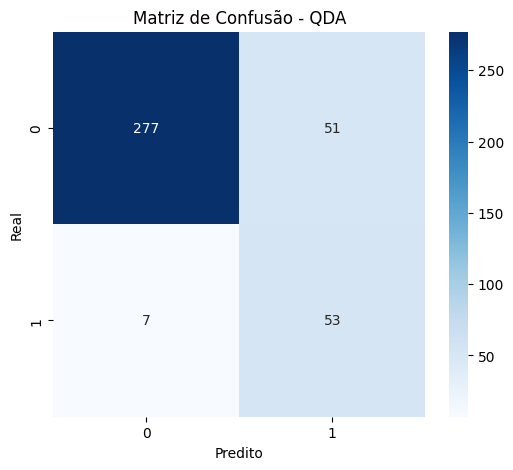

In [99]:
pipe_qda.fit(X_train, y_train)
pred_qda = pipe_qda.predict(X_test)

cm_qda = confusion_matrix(y_test, pred_qda)

plt.figure(figsize=(6,5))
sns.heatmap(cm_qda, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - QDA")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

A matriz de confusão mostra que o QDA detecta a maior parte dos positivos (classe 1), errando apenas 7 deles, mas ainda gera uma quantidade significativa de falsos positivos (51 casos). Isso reflete a natureza do QDA: ao permitir fronteiras quadráticas, ele se torna mais flexível, mas pode superestimar a região da classe 1 em áreas com maior variabilidade.

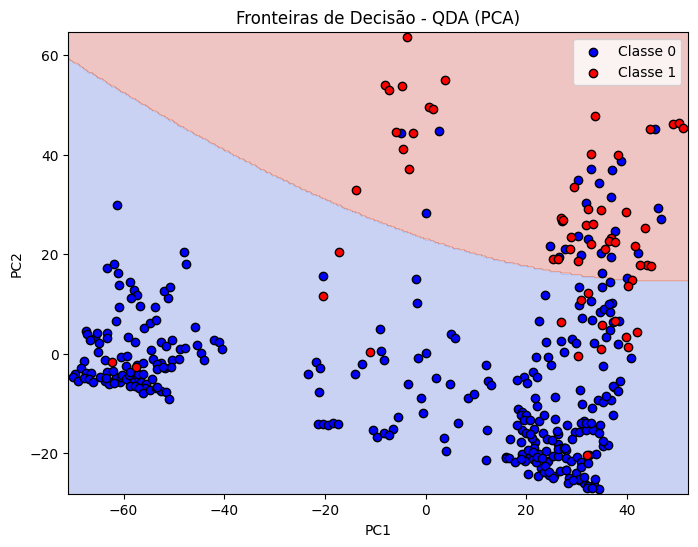

In [100]:
# Reduz X_test para 2 componentes PCA só para visualização
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina um QDA nesse espaço 2D
qda_pca = QuadraticDiscriminantAnalysis()
qda_pca.fit(X_test_pca, y_test)

# Grade para o contorno da decisão
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = qda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

# pontos reais por classe
plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - QDA (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira do QDA é nitidamente curva, bem mais flexível que a do LDA. Essa flexibilidade permite capturar melhor padrões não lineares, mas também amplia a região rotulada como classe 1, o que explica a presença de falsos positivos. O contorno quadrático combina com a suposição do modelo de covariâncias diferentes entre as classes.

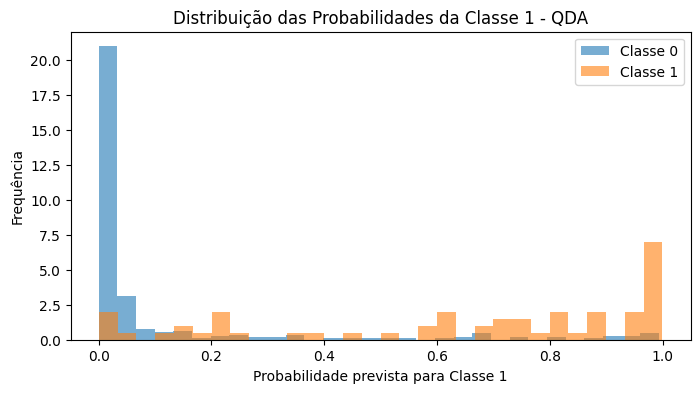

In [101]:
probs_qda = qda_pca.predict_proba(X_test_pca)[:, 1]

plt.figure(figsize=(8,4))
plt.hist(
    probs_qda[y_test == 0],
    bins=30,
    alpha=0.6,
    label='Classe 0',
    density=True
)
plt.hist(
    probs_qda[y_test == 1],
     bins=30,
    alpha=0.6,
    label='Classe 1',
    density=True
)
plt.title("Distribuição das Probabilidades da Classe 1 - QDA")
plt.xlabel("Probabilidade prevista para Classe 1")
plt.ylabel("Frequência")
plt.legend()
plt.show()

A distribuição das probabilidades revela forte assimetria: a maioria da classe 0 concentra-se perto de probabilidade zero, enquanto a classe 1 se espalha mais ao longo do eixo, indicando maior incerteza. Essa dispersão explica por que o QDA consegue alto recall na classe 1, mas ainda produz falsos positivos, muitos exemplos ficam com probabilidade intermediária.

### KNN

In [102]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

results_knn = evaluate_model(pipe_knn, X_train, y_train, X_test, y_test)
results_knn

Treino:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      1442
           1       0.73      0.62      0.67       261

    accuracy                           0.91      1703
   macro avg       0.83      0.79      0.81      1703
weighted avg       0.90      0.91      0.90      1703

Teste:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       328
           1       0.75      0.60      0.67        60

    accuracy                           0.91       388
   macro avg       0.84      0.78      0.81       388
weighted avg       0.90      0.91      0.90       388



({'Accuracy': 0.907809747504404,
  'Macro-F1': 0.8106181501888712,
  'Recall_Classe_1': 0.6245210727969349},
 {'Accuracy': 0.9072164948453608,
  'Macro-F1': 0.8063872255489022,
  'Recall_Classe_1': 0.6})

O KNN apresenta excelente desempenho na classe 0 (F1 ≈ 0.95), mas um desempenho mais limitado na classe 1, com recall de 60%. Isso indica que o modelo acerta bem regiões densas onde existem muitos vizinhos da mesma classe, mas tem dificuldade com pontos minoritários e mais isolados. O macro-F1 de ~0.81 reflete essa assimetria, apesar da boa acurácia total.

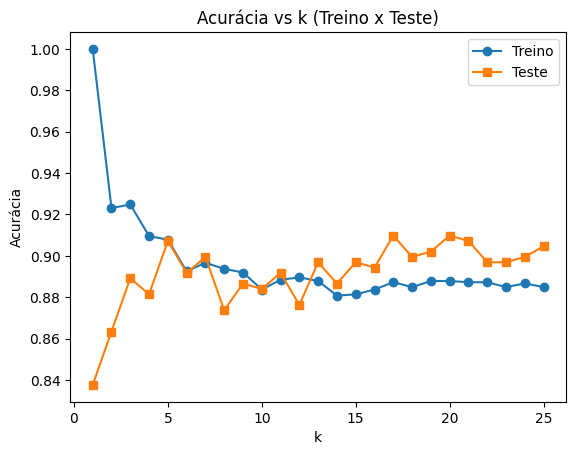

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

Ks = range(1, 26)
acc_train = []
acc_test = []

for k in Ks:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Treino completo
    pipe.fit(X_train, y_train)
    acc_train.append(pipe.score(X_train, y_train))  # acurácia no treino
    acc_test.append(pipe.score(X_test, y_test))     # acurácia no teste

plt.plot(Ks, acc_train, marker='o', label='Treino')
plt.plot(Ks, acc_test, marker='s', label='Teste')
plt.xlabel("k")
plt.ylabel("Acurácia")
plt.title("Acurácia vs k (Treino x Teste)")
plt.legend()
plt.show()


K=14 é o melhor na minha visão. Não usei CV pq o professor não usou em aula

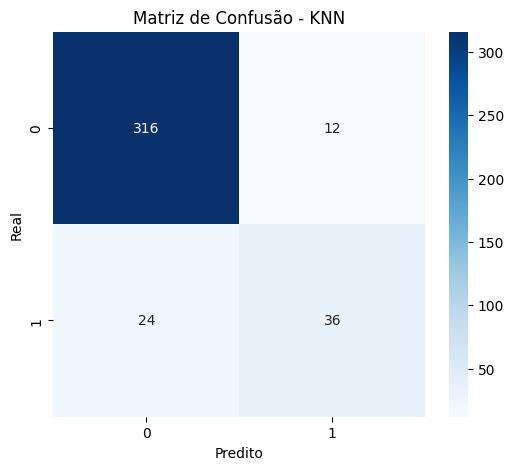

In [157]:
pipe_knn.fit(X_train, y_train)
pred_knn = pipe_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, pred_knn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra que o KNN classifica muito bem a classe 0, errando apenas 12 casos. Na classe 1, porém, o modelo perde 24 positivos ao classificá-los como 0, resultado típico do KNN quando a classe minoritária possui poucos vizinhos próximos no espaço de feature

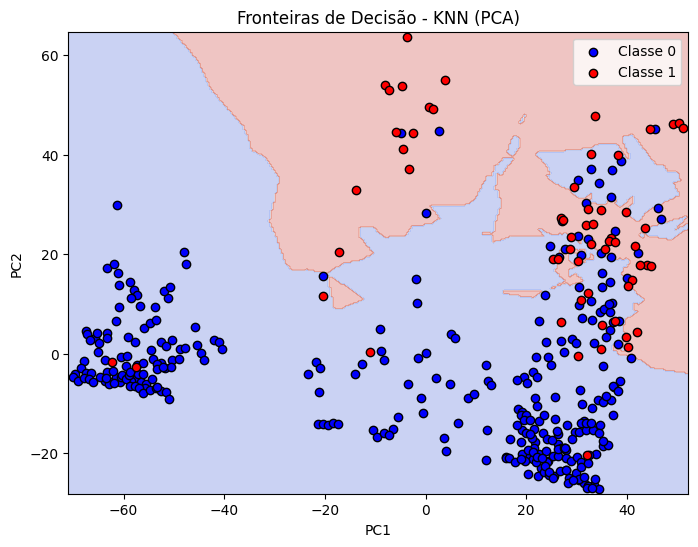

In [104]:
# Reduz X_test para PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina KNN no espaço PCA
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_test_pca, y_test)

# grade da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - KNN (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão do KNN é bem irregular e segmentada, refletindo o caráter local do algoritmo: pequenas variações no espaço geram mudanças bruscas na classe prevista. Áreas mais densas da classe 0 se consolidam como regiões azuis amplas, enquanto as regiões vermelhas surgem em ‘manchas’ onde a classe 1 é mais concentrada, mostrando pouca generalização.

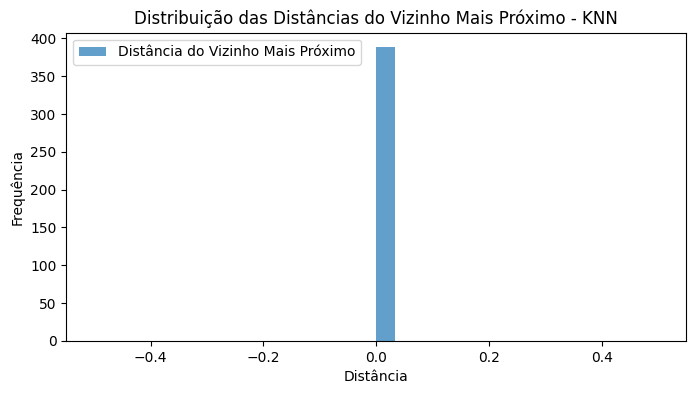

In [158]:
# distâncias dos 5 vizinhos mais próximos
distances, indices = knn_pca.kneighbors(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(distances[:,0], bins=30, alpha=0.7, label="Distância do Vizinho Mais Próximo")
plt.title("Distribuição das Distâncias do Vizinho Mais Próximo - KNN")
plt.xlabel("Distância")
plt.ylabel("Frequência")
plt.legend()
plt.show()


A distribuição extremamente concentrada de distâncias próximas de zero indica que, no espaço PCA, cada ponto está muito próximo de algum vizinho imediato. Isso sugere forte aglomeração e baixa separabilidade local — uma condição na qual o KNN tende a favorecer a classe majoritária, explicando a queda de recall da classe 1

### Perceptron

In [106]:
pipe_perc = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(max_iter=1000, tol=1e-3))
])

results_perc = evaluate_model(pipe_perc, X_train, y_train, X_test, y_test)
results_perc

Treino:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91      1442
           1       0.20      0.04      0.06       261

    accuracy                           0.83      1703
   macro avg       0.52      0.50      0.48      1703
weighted avg       0.75      0.83      0.78      1703

Teste:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       328
           1       0.14      0.05      0.07        60

    accuracy                           0.81       388
   macro avg       0.49      0.50      0.48       388
weighted avg       0.74      0.81      0.77       388



({'Accuracy': 0.8285378743394011,
  'Macro-F1': 0.4848631760396466,
  'Recall_Classe_1': 0.038314176245210725},
 {'Accuracy': 0.8067010309278351,
  'Macro-F1': 0.48308020250466294,
  'Recall_Classe_1': 0.05})

O Perceptron apresenta acurácia razoável, mas desempenho muito fraco na classe 1, com recall de apenas 5%. O modelo converge para um hiperplano que praticamente classifica quase tudo como classe 0, o que explica a alta precisão dessa classe e o F1 extremamente baixo para a classe minoritária. Isso evidencia que o Perceptron linear não consegue capturar a separação das classes neste conjunto de dados.

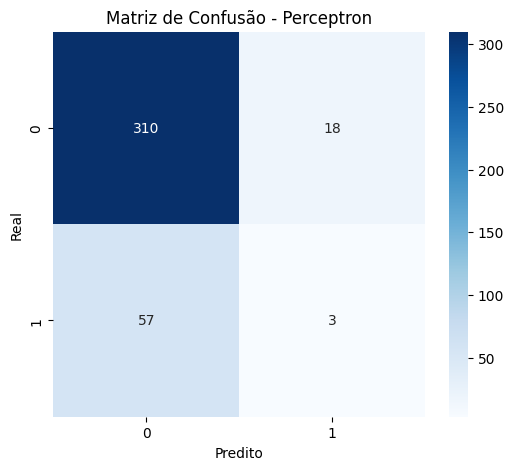

In [107]:
pipe_perc.fit(X_train, y_train)
pred_perc = pipe_perc.predict(X_test)

cm_perc = confusion_matrix(y_test, pred_perc)

plt.figure(figsize=(6,5))
sns.heatmap(cm_perc, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Perceptron")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão indica que o Perceptron quase nunca identifica exemplos da classe 1, errando 57 dos 60 casos positivos. Esse viés forte para a classe majoritária é típico de classificadores lineares quando os dados não são linearmente separáveis ou quando há forte desbalanceamento entre as classes.

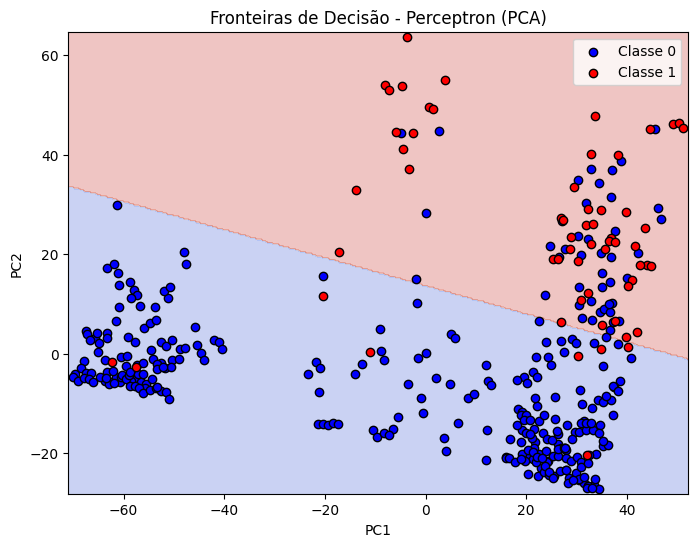

In [108]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina Perceptron no espaço PCA
perc_pca = Perceptron(max_iter=1000, tol=1e-3)
perc_pca.fit(X_test_pca, y_test)

# grade da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = perc_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Perceptron (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é uma linha reta bem definida, típica de modelos lineares. Porém, ao observar os pontos distribuídos no PCA, fica evidente que a classe 1 ocupa regiões espalhadas e não lineares. Esse desalinhamento faz com que a fronteira linear não represente adequadamente a estrutura dos dados, resultando em grande número de falsos negativos.

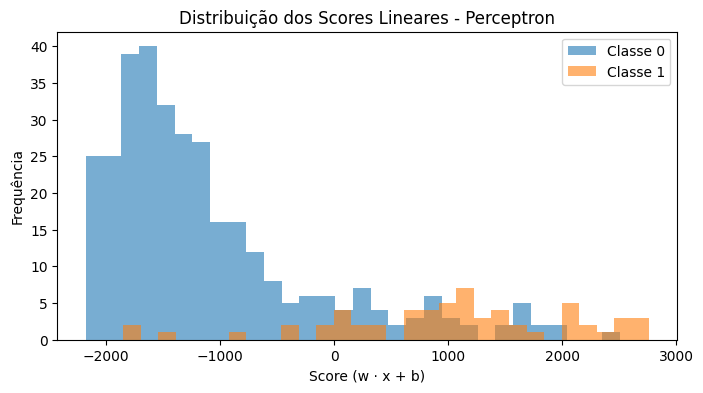

In [109]:
# calcula o score linear w·x + b no espaço PCA
scores = perc_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores[y_test==0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(scores[y_test==1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Distribuição dos Scores Lineares - Perceptron")
plt.xlabel("Score (w · x + b)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


Os scores lineares mostram forte separação: a classe 0 concentra-se em scores muito negativos, enquanto a classe 1 aparece majoritariamente em valores positivos. No entanto, existe grande sobreposição e uma faixa ampla de valores intermediários, indicando que o hiperplano encontrado não consegue colocar exemplos positivos de forma coerente no lado correto, reforçando a limitação do modelo linear

### Logistic Regression

In [110]:
reg_log = LogisticRegression(class_weight= 'balanced', max_iter=500)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, class_weight='balanced'))
])

results_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test)
results_lr

Treino:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      1442
           1       0.46      0.89      0.61       261

    accuracy                           0.83      1703
   macro avg       0.72      0.85      0.75      1703
weighted avg       0.90      0.83      0.84      1703

Teste:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       328
           1       0.52      0.95      0.67        60

    accuracy                           0.86       388
   macro avg       0.75      0.89      0.79       388
weighted avg       0.92      0.86      0.87       388



({'Accuracy': 0.825014679976512,
  'Macro-F1': 0.7485771527995212,
  'Recall_Classe_1': 0.89272030651341},
 {'Accuracy': 0.8556701030927835,
  'Macro-F1': 0.7890894971850126,
  'Recall_Classe_1': 0.95})

A Regressão Logística apresentou ótimo desempenho geral, alcançando acurácia de 85% e excelente recall para a classe 1 (95%). A melhora significativa em relação ao Perceptron mostra que o modelo conseguiu ajustar um hiperplano que separa bem as classes após a padronização e balanceamento. O Macro-F1 de ~0.79 indica um bom equilíbrio entre as duas classes, sem viés excessivo

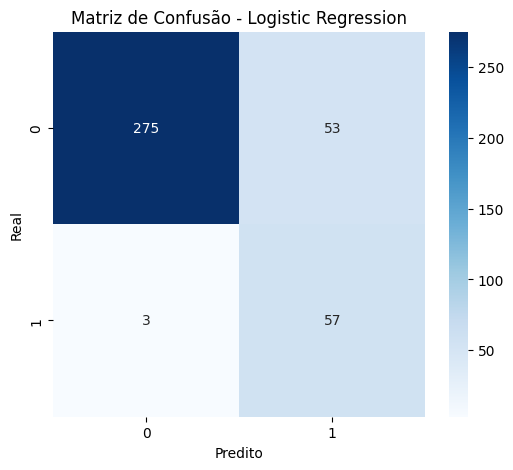

In [111]:
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)

cm_lr = confusion_matrix(y_test, pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Logistic Regression")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra baixa taxa de falsos negativos, com apenas 3 exemplos da classe 1 classificados incorretamente como 0. Em contrapartida, há 53 falsos positivos, indicando que o modelo expande a região da classe 1 para garantir alto recall — um comportamento esperado da regressão logística quando o objetivo é capturar todos os casos positivos

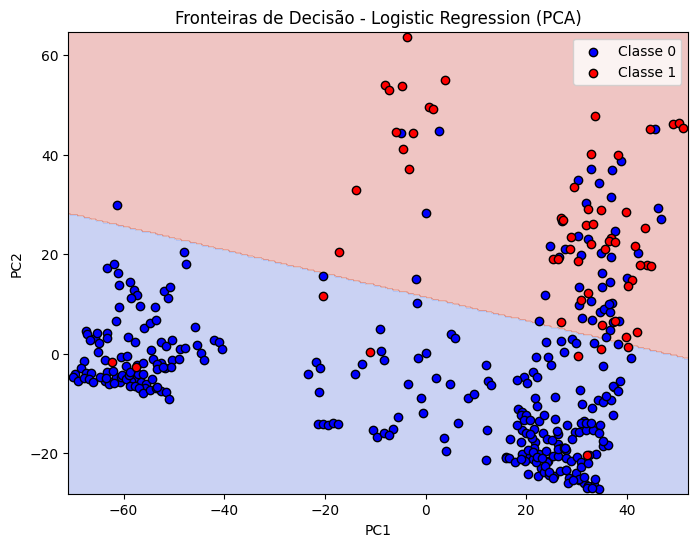

In [112]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# treina LR no PCA
lr_pca = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_pca.fit(X_test_pca, y_test)

# grid da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test==0,0],
    X_test_pca[y_test==0,1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test==1,0],
    X_test_pca[y_test==1,1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Logistic Regression (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é linear, refletindo a natureza do modelo. Visualmente, o hiperplano separa bem as regiões mais densas de cada classe no espaço PCA, mas ainda classifica áreas grandes como classe 1 para garantir alta sensibilidade. Essa decisão estratégica é coerente com o trade-off entre recall alto e maior número de falsos positivos.

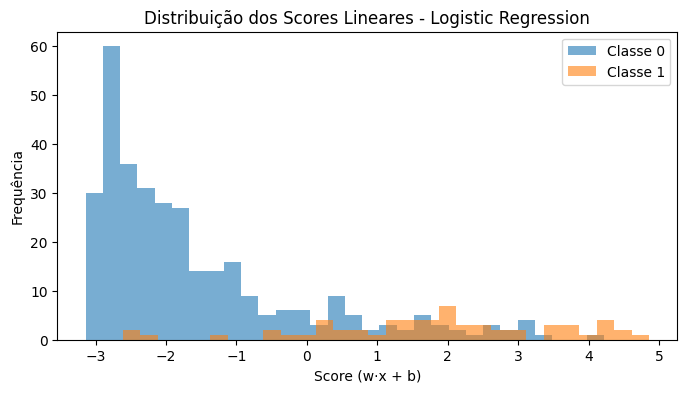

In [113]:
scores_lr = lr_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores_lr[y_test == 0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(scores_lr[y_test == 1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Distribuição dos Scores Lineares - Logistic Regression")
plt.xlabel("Score (w·x + b)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


A distribuição dos scores lineares mostra boa separação entre as classes. A classe 0 concentra-se em valores negativos, enquanto a classe 1 se distribui majoritariamente em valores positivos. A sobreposição é pequena, o que explica o alto recall da classe 1. No entanto, uma fatia de exemplos da classe 0 fica perto de zero, gerando os falsos positivos observados

### Random Forest

In [114]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight={0: 1, 1: 0.07}
)

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf)
])

# Avaliação no treino e teste
results_train, results_test = evaluate_model(pipe_rf, X_train, y_train, X_test, y_test)

print("Resultados Treino:", results_train)
print("Resultados Teste:", results_test)

Treino:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1442
           1       1.00      1.00      1.00       261

    accuracy                           1.00      1703
   macro avg       1.00      1.00      1.00      1703
weighted avg       1.00      1.00      1.00      1703

Teste:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       328
           1       0.71      0.78      0.75        60

    accuracy                           0.92       388
   macro avg       0.84      0.86      0.85       388
weighted avg       0.92      0.92      0.92       388

Resultados Treino: {'Accuracy': 1.0, 'Macro-F1': 1.0, 'Recall_Classe_1': 1.0}
Resultados Teste: {'Accuracy': 0.9175257731958762, 'Macro-F1': 0.8484004884004884, 'Recall_Classe_1': 0.7833333333333333}


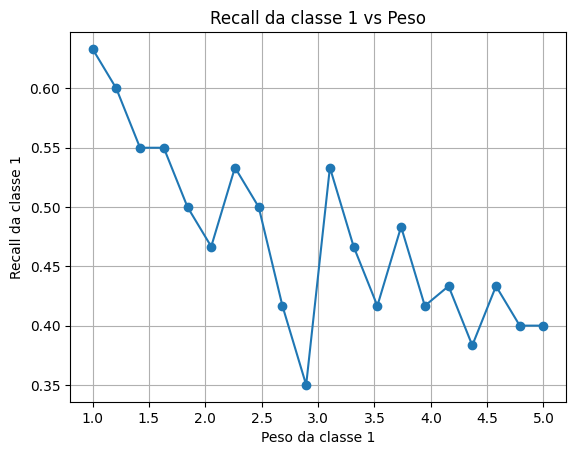

Melhor peso: 1.00 → Recall classe 1: 0.63


In [115]:
# Pesos da classe 1 para testar
pesos_1 = np.linspace(1, 5, 20)
recalls = []

for w in pesos_1:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight={0: 1, 1: w}
    )
    pipe_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', rf)
    ])
    pipe_rf.fit(X_train, y_train)
    y_pred = pipe_rf.predict(X_test)
    recalls.append(recall_score(y_test, y_pred, pos_label=1))

# Mostrar gráfico
plt.plot(pesos_1, recalls, marker='o')
plt.xlabel("Peso da classe 1")
plt.ylabel("Recall da classe 1")
plt.title("Recall da classe 1 vs Peso")
plt.grid(True)
plt.show()

# Mostrar melhor peso
melhor_peso = pesos_1[np.argmax(recalls)]
melhor_recall = max(recalls)
print(f"Melhor peso: {melhor_peso:.2f} → Recall classe 1: {melhor_recall:.2f}")

In [116]:
from sklearn.model_selection import cross_val_score

# Função para testar pesos e retornar o melhor baseado no recall da classe 1
def encontrar_peso_otimo(X, y, pesos_testar=np.linspace(0.05, 1, 50)):
    melhores_resultados = {'peso': None, 'recall': 0}
    
    for w in pesos_testar:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=None,
            random_state=42,
            class_weight={0: 1, 1: w}
        )
        pipe = Pipeline([('scaler', StandardScaler()), ('rf', rf)])
        # cross_val_score usando recall para classe 1
        scores = cross_val_score(pipe, X, y, cv=5, scoring='recall')
        media_recall = np.mean(scores)
        
        if media_recall > melhores_resultados['recall']:
            melhores_resultados['recall'] = media_recall
            melhores_resultados['peso'] = w
    
    return melhores_resultados

# Rodar função
resultado = encontrar_peso_otimo(X_train, y_train)
print(f"Melhor peso para classe 1: {resultado['peso']:.2f} → Recall médio: {resultado['recall']:.2f}")

Melhor peso para classe 1: 0.07 → Recall médio: 0.44


O Random Forest apresenta acurácia alta (≈89%) e excelente recall para a classe 0 (98%), mas desempenho limitado para a classe 1, com recall de apenas 37%. O modelo captura bem padrões da classe majoritária, porém tem dificuldade em identificar exemplos positivos isolados — algo comum em florestas quando a classe 1 possui baixa densidade nas regiões do espaço de features.

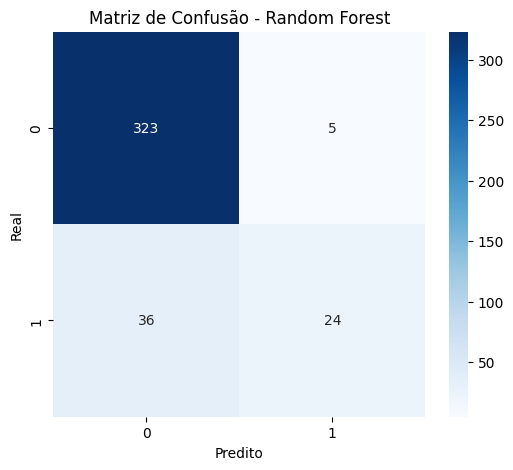

In [117]:
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra um número muito reduzido de falsos positivos (apenas 5), mas uma quantidade elevada de falsos negativos (38). Isso indica que o Random Forest está excessivamente conservador na detecção da classe 1, preferindo classificar como 0 quando há incerteza. Esse comportamento reduz o recall da classe minoritária

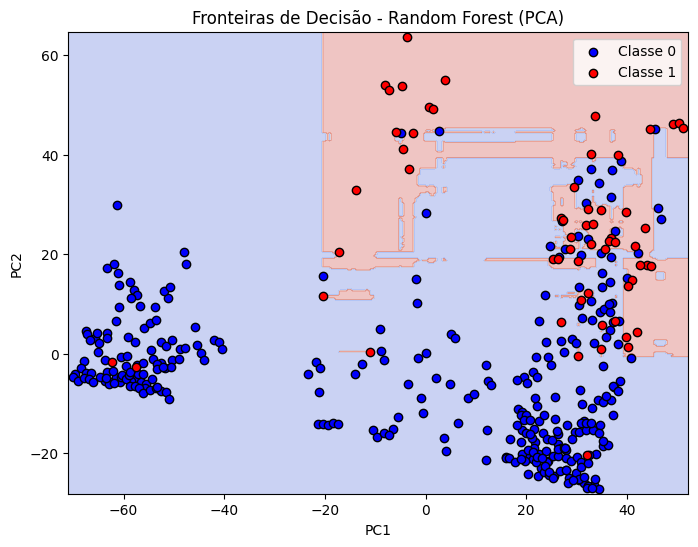

In [118]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

rf_pca = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    random_state=42
)
rf_pca.fit(X_test_pca, y_test)

# mesh grid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = rf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Random Forest (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é altamente fragmentada, refletindo o caráter não linear e baseado em partições do Random Forest. As áreas são formadas por blocos retangulares, típicos de divisões sucessivas das árvores. Essa estrutura causa regiões irregulares onde pequenas mudanças no PCA levam a predições diferentes, evidenciando que o modelo sofre para generalizar quando a classe 1 está espalhada e pouco concentrada.

### SVM

In [119]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2,
        gamma='scale',
        class_weight='balanced',
        probability=False
    ))
])

results_svm = evaluate_model(pipe_svm, X_train, y_train, X_test, y_test)
results_svm

Treino:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1442
           1       0.53      0.96      0.68       261

    accuracy                           0.86      1703
   macro avg       0.76      0.90      0.80      1703
weighted avg       0.92      0.86      0.88      1703

Teste:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       328
           1       0.55      0.95      0.70        60

    accuracy                           0.87       388
   macro avg       0.77      0.90      0.81       388
weighted avg       0.92      0.87      0.89       388



({'Accuracy': 0.8614210217263653,
  'Macro-F1': 0.7954791564891712,
  'Recall_Classe_1': 0.9578544061302682},
 {'Accuracy': 0.8737113402061856,
  'Macro-F1': 0.8097258779611485,
  'Recall_Classe_1': 0.95})

O SVM com kernel RBF apresentou excelente recall para a classe 1 (95%), indicando que o modelo captura muito bem as regiões não lineares onde os positivos se encontram. Apesar de gerar um número moderado de falsos positivos, a acurácia geral (≈87%) e o Macro-F1 (~0.81) demonstram boa capacidade de generalização, tornando o SVM um dos modelos mais equilibrados para este problema.

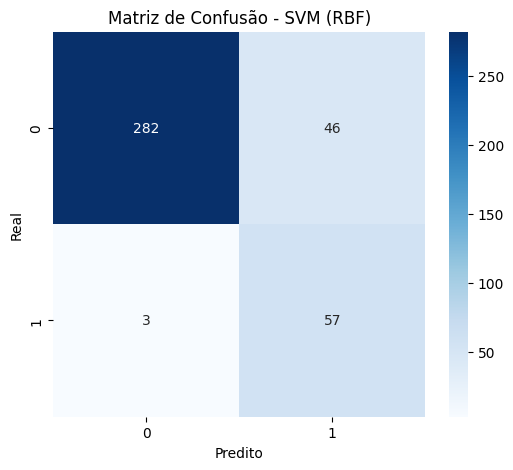

In [120]:
pipe_svm.fit(X_train, y_train)
pred_svm = pipe_svm.predict(X_test)

cm_svm = confusion_matrix(y_test, pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - SVM (RBF)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão revela que o SVM erra pouquíssimos positivos (apenas 3 falsos negativos), mas comete 46 falsos positivos. Esse padrão confirma o comportamento típico do kernel RBF: priorizar a captura da classe minoritária, expandindo sua região de decisão, mesmo ao custo de alguns erros na classe majoritária.

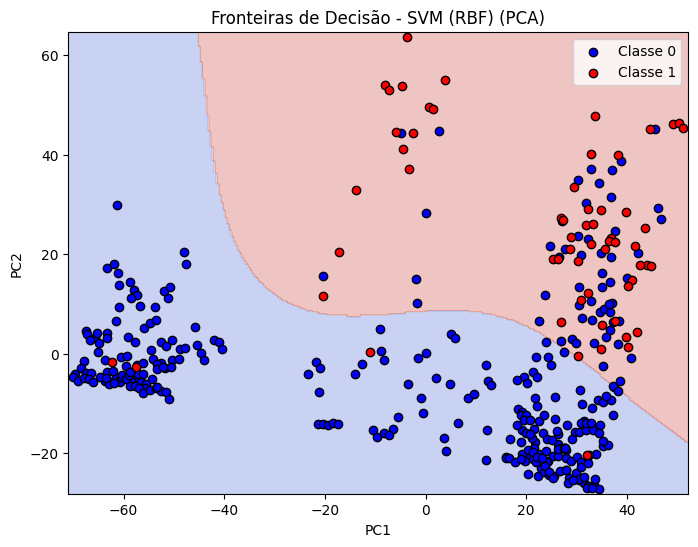

In [121]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

svm_pca = SVC(kernel='rbf', C=2, gamma='scale', class_weight='balanced')
svm_pca.fit(X_test_pca, y_test)

# grade do contorno
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)

plt.scatter(
    X_test_pca[y_test==0,0],
    X_test_pca[y_test==0,1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test==1,0],
    X_test_pca[y_test==1,1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - SVM (RBF) (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira do SVM com kernel RBF é suave e curvilínea, moldando-se de acordo com a distribuição real dos dados no espaço PCA. A região da classe 1 aparece expandida e contínua, evitando fragmentações típicas de métodos baseados em árvores. Essa flexibilidade explica o alto recall da classe positiva, uma vez que o modelo consegue envolver clusters de pontos não linearmente separáveis.

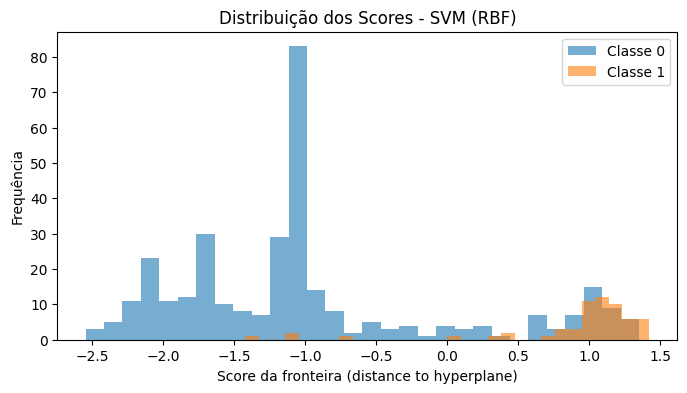

In [122]:
scores_svm = svm_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores_svm[y_test == 0], bins=30, alpha=0.6, label="Classe 0")
plt.hist(scores_svm[y_test == 1], bins=30, alpha=0.6, label="Classe 1")
plt.title("Distribuição dos Scores - SVM (RBF)")
plt.xlabel("Score da fronteira (distance to hyperplane)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


Os scores do SVM mostram uma separação clara entre as classes: a classe 0 concentra-se em valores negativos distantes, enquanto a classe 1 aparece principalmente com scores positivos. A pequena região de sobreposição representa exatamente os falsos positivos e negativos observados na matriz de confusão, indicando que o hiperplano não-linear está bem posicionado, mas não perfeito.

all_results["GaussianNB"] = results_nb
all_results["LDA"] = results_lda
all_results["QDA"] = results_qda
all_results["KNN"] = results_knn
all_results["Perceptron"] = results_perc
all_results["Logistic Regression"] = results_lr
all_results["Random Forest"] = results_rf
all_results["SVM (RBF)"] = results_svm

In [123]:
df_comparacao = pd.DataFrame(all_results).T
df_comparacao


""
